In [1]:
import torch
import torchvision
import torchvision.models as models
from   torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

default_params = {
    "batch_size_train": 64,
    "batch_size_test" : 100,
    "random_seed"     : 48,
    "learning_rate"   : 0.001,
    "momentum"        : 0.5

}

In [87]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [88]:
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transformers)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=default_params["batch_size_train"], shuffle=True)

In [89]:
test_dataset = torchvision.datasets.MNIST('./data', train=False,download=True, transform=transformers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=default_params["batch_size_test"], shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


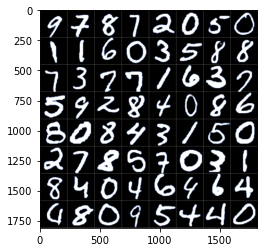

In [90]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [91]:
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18(pretrained=True)
        vgg = models.vgg16(pretrained=True)
        self.features_resnet = nn.Sequential(*(list(resnet18.children())[0:8]))
        
        
        self.features = list(vgg.features)
        self.features_vgg = nn.Sequential(*self.features)
        
        self.liner_layer1 = nn.Linear(25088, 512)
        
        
        self.liner_layer2 = nn.Linear(512, 64)
        self.liner_layer3 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, inputs):
        resnet_feature = self.features_resnet(inputs)
#         print("resnet feature shape = ", resnet_feature.shape)
        
        vgg_feature = self.features_vgg(inputs)
#         print("vgg feature map shape", vgg_feature.shape)
        
        features = vgg_feature.add(resnet_feature)
#         print("adding both features", features.shape)

        features = torch.flatten(features)
        
        features = self.liner_layer1(features)
        features = self.dropout(features)
        
        features = self.liner_layer2(features)
        feature = self.dropout(features)
        
        features = self.liner_layer3(features)
        
        return F.log_softmax(features)
        
        
        
        

In [92]:
network = CRNN().to(device)
optimizer =  torch.optim.SGD(network.parameters(), lr=default_params["learning_rate"],momentum=default_params["momentum"])

In [93]:
n_epochs = 3
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_oader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [94]:
for epoch in range(1, n_epochs + 1):
    train(epoch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1605632 and 25088x512)

In [63]:
# from vit_pytorch.distill import DistillableViT, DistillWrapper


# v = DistillableViT(
#     image_size = 256,
#     patch_size = 32,
#     num_classes = 10,
#     dim = 1024,
#     depth = 6,
#     heads = 8,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# )

# distiller = DistillWrapper(
#     student = v,
#     teacher = CRNN().to(device),
#     temperature = 3,           # temperature of distillation
#     alpha = 0.5,               # trade between main loss and distillation loss
#     hard = False               # whether to use soft or hard distillation
# )

# for epoch in range(2):
#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         loss = distiller(inputs, labels)
#         loss.backward()
#         running_loss += loss.item()
#         if i % 100 == 0:
#             print("epochs {} with loss {} at iter".format(epoch, running_loss, i)) 
# #             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
# print('Finished Training')

RuntimeError: The size of tensor a (7) must match the size of tensor b (10) at non-singleton dimension 3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1